In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean
import pytesseract

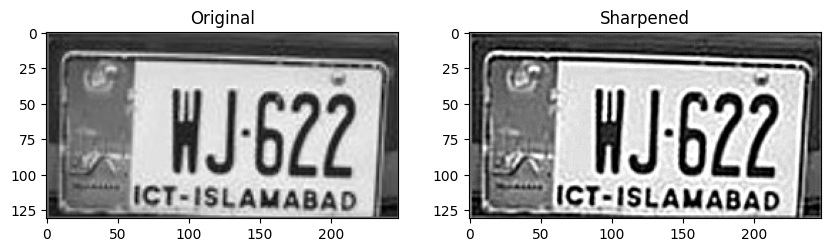

In [4]:
img = cv2.imread("C:\\Users\\DELL\\Documents\\GitHub\\Number-Plate-Recognition-System\\cropped.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# blurred_gray_img = gaussian(gray)
# plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)) 
# Apply GaussianBlur to reduce noise and make the image less blurry
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply image sharpening using a kernel
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1, 9, -1],
                              [-1, -1, -1]])
sharpened = cv2.filter2D(blurred, -1, sharpening_kernel)

# Display the original and sharpened images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(gray, cmap='gray'), plt.title('Original')
plt.subplot(1, 2, 2), plt.imshow(sharpened, cmap='gray'), plt.title('Sharpened')
plt.show()

In [5]:
# Apply noise reduction and edge detection
bfilter = cv2.bilateralFilter(sharpened, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)

In [6]:
# # Apply thresholding
ret, thresh = cv2.threshold(edged, 127, 255, cv2.THRESH_BINARY)

In [7]:
# # Perform connected component labeling
num_labels, labels = cv2.connectedComponents(thresh)

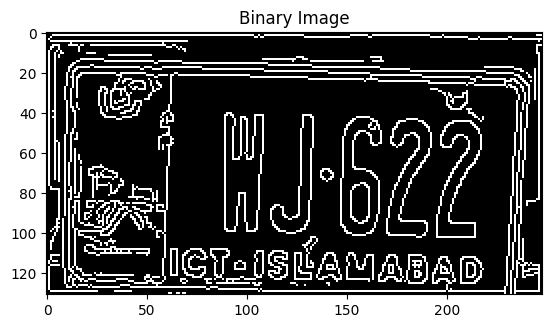

In [8]:
 # Visualize the binary image
plt.imshow(thresh, cmap='gray')
plt.title('Binary Image')
plt.show()


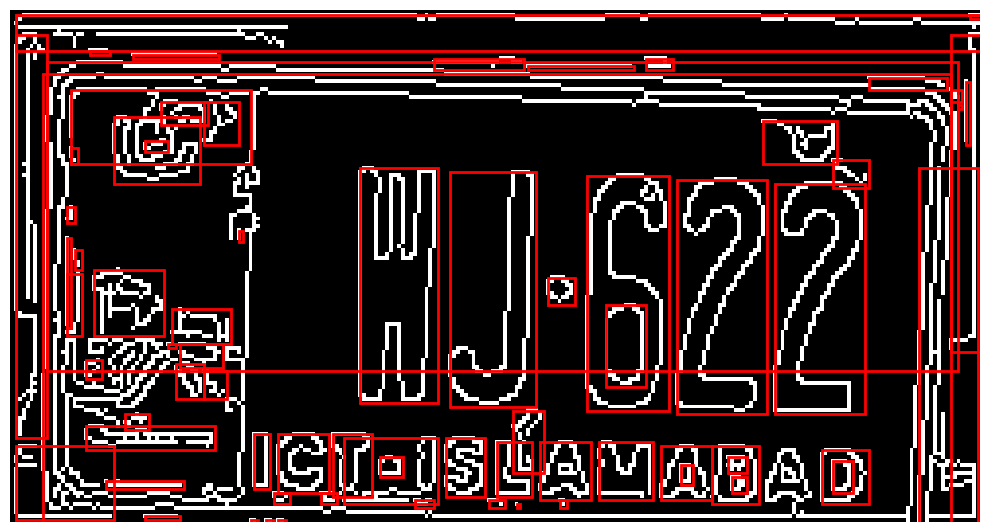

In [9]:
label_image = label(thresh, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(thresh, cmap="gray")

for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

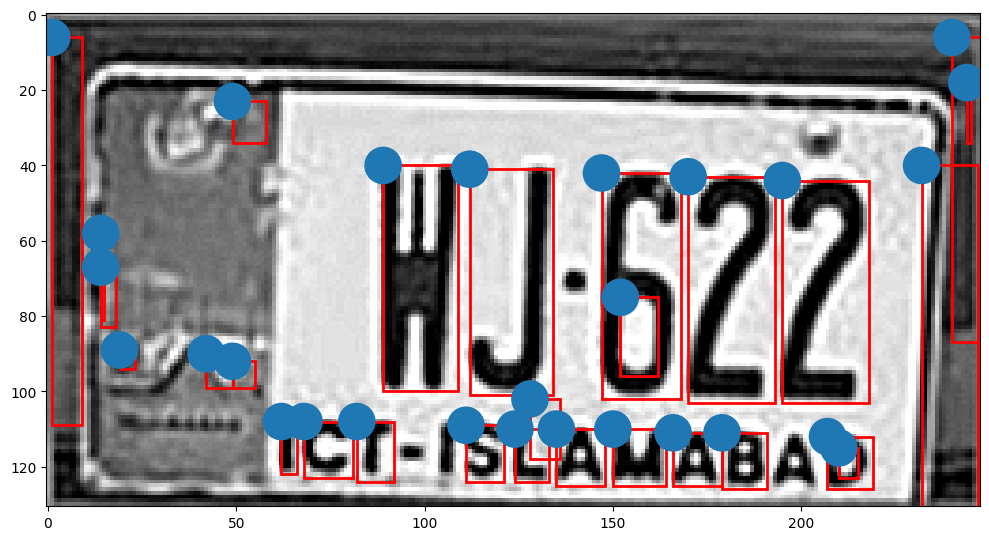

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(sharpened, cmap="gray")

text_like_regions = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    w = maxc - minc
    h = maxr - minr
    
    asr = w/h
    
    region_area = w*h
    
    wid,hei = sharpened.shape
    img_area = wid*hei
    
    # The aspect ratio is less than 1 to eliminate highly elongated regions
    # The size of the region should be greater than 15 pixels but smaller than 1/5th of the image
    # dimension to be considered for further processing
    if region_area > 15 and region_area < (0.2 * img_area) and asr < 1 and h > w:
        #print(w, h, i, region.area, region.bbox)
        text_like_regions.append(region)

all_points = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)
    all_points.append([minc, minr, maxc, maxr])
    
plt.tight_layout()
plt.show() 

In [ ]:
# Extract text from each text-like region using Tesseract OCR
extracted_text = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    
    # Crop the region of interest (ROI)
    roi = sharpened[minr:maxr, minc:maxc]
    
    # Apply OCR using pytesseract
    text = pytesseract.image_to_string(roi, config='--psm 8')  # PSM 8 is for treating the image as a single word
    extracted_text.append(text.strip())

    # Visualization
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    circ = mpatches.Circle((minc, minr), radius=5)
    ax.add_patch(circ)

    # Display the extracted text
    plt.text(minc, minr, text, color='red', fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()

# Print the extracted text
print("Extracted Text:", extracted_text)

In [11]:
# Extract text-like regions using contour analysis
extracted_regions = []
for region in text_like_regions:
    minr, minc, maxr, maxc = region.bbox
    
    # Crop the region of interest (ROI)
    roi = sharpened[minr:maxr, minc:maxc]
    
    # Find contours in the ROI
    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if any contours are found
    if contours:
        extracted_regions.append((minr, minc, maxr, maxc))

        # Visualization
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        circ = mpatches.Circle((minc, minr), radius=5)
        ax.add_patch(circ)

plt.tight_layout()
plt.show()

# Print the coordinates of extracted regions
print("Extracted Regions:", extracted_regions)

<Figure size 640x480 with 0 Axes>

Extracted Regions: [(6, 1, 109, 9), (6, 240, 87, 248), (18, 244, 34, 245), (23, 49, 34, 58), (40, 89, 100, 109), (40, 232, 131, 247), (41, 112, 101, 134), (42, 147, 102, 168), (43, 170, 103, 193), (44, 195, 103, 218), (58, 14, 81, 15), (67, 14, 83, 18), (75, 152, 96, 162), (89, 19, 94, 23), (90, 42, 99, 49), (92, 49, 99, 55), (102, 128, 118, 136), (108, 62, 122, 66), (108, 68, 123, 81), (108, 82, 124, 92), (109, 111, 124, 121), (110, 124, 124, 133), (110, 135, 125, 148), (110, 150, 125, 164), (111, 166, 125, 179), (111, 179, 126, 191), (112, 207, 126, 219), (115, 210, 123, 215)]
